In [1]:
%pwd

'/home/GPU/GallupWellBeingGroup/Code'

In [2]:
cd ..

/home/GPU/GallupWellBeingGroup


/home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Import Pacakge

In [3]:
import os 
import pandas as pd
import xgboost as xgb
import random
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report

In [4]:
#pip install shap

In [5]:
import shap
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [6]:
#pip install scikit-optimize

In [7]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load and make dataset

In [8]:
parquet_file_path = 'Data/GallupWB_WashdataEnergy_1.967Mvar_v3.parquet'

In [9]:
Df = pd.read_parquet(parquet_file_path, engine='pyarrow')

In [10]:
Df.shape

(1967478, 67)

In [11]:
Df.columns

Index(['Disability', 'Food', 'Shelter', 'Relatives', 'Satisfy_life',
       'Wellrested', 'Treated_respect', 'Smile_Laugh', 'Learn_interesting',
       'Enjoyment', 'Physical_pain', 'Worry', 'Sadness', 'Stress', 'Anger',
       'Satisfied_city', 'Move_city', 'Recommend_city', 'Find_job',
       'Public_transportation', 'Roads_highways', 'Education', 'Air_quality',
       'Water_quality', 'Health_care', 'Good_housing', 'Friends_make',
       'Racial_minority', 'Gay_les', 'Immigrants', 'Donation', 'Voluntary',
       'Help_stranger', 'Voice_opinion', 'Confidence', 'Safety', 'Steal',
       'Assualted', 'Children_respected', 'Children_learn', 'Women_respected',
       'Preserve_environment', 'Freedom_life', 'Military', 'Judicial_system',
       'Government', 'Banks', 'election_honesty', 'Corruption_business',
       'Corruption_government', 'Gender', 'Leadership_country',
       'Marital_status', 'Acess_internet', 'Use_internet', 'Phone_internet',
       'Life_standard', 'Economic_trend',

## Check difference between 

## Shuffle Conversion for Step 1

In [12]:
Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
Df['COUNTRY_ISO3'] = Df['COUNTRY_ISO3'].astype('category')

In [14]:
ye1 = Df['Economic_trend']

In [15]:
Xe1 = Df.drop(columns=['Wellbeing_ladder','Economic_trend'])

In [16]:
Xe1_train, Xe1_test, ye1_train, ye1_test = train_test_split(Xe1, ye1, test_size=0.1, random_state=42)

In [17]:
Xe1_train.dtypes

Disability             float64
Food                   float64
Shelter                float64
Relatives              float64
Satisfy_life           float64
                        ...   
Employment             float64
Economic_condition     float64
INCOME_2               float64
COUNTRY_ISO3          category
wave                   float64
Length: 65, dtype: object

In [18]:
Xe1_test.dtypes

Disability             float64
Food                   float64
Shelter                float64
Relatives              float64
Satisfy_life           float64
                        ...   
Employment             float64
Economic_condition     float64
INCOME_2               float64
COUNTRY_ISO3          category
wave                   float64
Length: 65, dtype: object

In [19]:
Xe1_train.shape

(1770730, 65)

## Model and Tuning Hyper for Step 1

Economic_trend Model: Isolate indirect effect of features on Wellbeing

### Encode COUNTRY_IS03

In [20]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Fit the LabelEncoder on the categorical column and transform it
Xe1_train['COUNTRY_ISO3'] = le.fit_transform(Xe1_train['COUNTRY_ISO3'])
Xe1_test['COUNTRY_ISO3'] = le.transform(Xe1_test['COUNTRY_ISO3'])

# Ensure all columns are of type float64
Xe1_train = Xe1_train.astype('float64')
Xe1_test = Xe1_test.astype('float64')

# Verify data types
print("Data types in Xe1_train:")
print(Xe1_train.dtypes)

print("Data types in Xe1_test:")
print(Xe1_test.dtypes)

Data types in Xe1_train:
Disability            float64
Food                  float64
Shelter               float64
Relatives             float64
Satisfy_life          float64
                       ...   
Employment            float64
Economic_condition    float64
INCOME_2              float64
COUNTRY_ISO3          float64
wave                  float64
Length: 65, dtype: object
Data types in Xe1_test:
Disability            float64
Food                  float64
Shelter               float64
Relatives             float64
Satisfy_life          float64
                       ...   
Employment            float64
Economic_condition    float64
INCOME_2              float64
COUNTRY_ISO3          float64
wave                  float64
Length: 65, dtype: object


### Bayes Search CV for Step 1

Bayes for accuracy

In [21]:
param_space = {
    'n_estimators': Integer(100, 3000),
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'max_depth': Integer(3, 14),
    'subsample': Real(0.5, 1.0),
    'min_child_weight': Real(0.001, 10, prior='log-uniform'),
    'max_delta_step': Real(0.001, 10, prior='log-uniform'),
    'reg_lambda': Real(0.001, 10, prior='log-uniform'),
    'reg_alpha': Real(0.001, 10, prior='log-uniform'),
    'gamma': Real(0.001, 10, prior='log-uniform')
}

In [22]:
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',tree_method='hist', device='cuda', random_state=42, enable_categorical=True  )

In [23]:
class RandomRunNFoldsKFold(KFold):
    def __init__(self, n_splits=10, random_state=None, run_splits=3, **kwargs):
        super().__init__(n_splits=n_splits, shuffle=True, random_state=random_state, **kwargs)
        self.random_state = random_state
        self.actual_splits = run_splits  # Number of actual splits to use

    def split(self, X, y=None, groups=None):
        folds = list(super().split(X, y, groups))
        if self.random_state is not None:
            random.seed(self.random_state)
        selected_folds = random.sample(folds, self.actual_splits)
        for train_index, test_index in selected_folds:
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.actual_splits

In [24]:
rkfcv = RandomRunNFoldsKFold(n_splits=10, run_splits=3, random_state=42)

In [37]:
bayes_research = BayesSearchCV(
    estimator=xgb_classifier,
    search_spaces=param_space,
    n_iter=20,
    scoring='accuracy',
    cv=rkfcv,
    n_jobs = 1,
    n_points = 1,
    verbose=2,
    random_state=42,
    return_train_score = True
)

In [ ]:
bayes_research.fit(Xe1, ye1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=6, min_child_weight=0.47928274405969296, n_estimators=1301, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 1.5min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=6, min_child_weight=0.47928274405969296, n_estimators=1301, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 1.5min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=6, min_child_weight=0.47928274405969296, n_estimators=1301, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 1.5min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gamma=2.2364

In [1]:
bayes_search.best_params_

NameError: name 'bayes_search' is not defined

#### Bayes for R2

In [25]:
bayes_search = BayesSearchCV(
    estimator=xgb_classifier,
    search_spaces=param_space,
    n_iter=20,
    scoring='r2',
    cv=rkfcv,
    n_jobs = 1,
    n_points = 1,
    verbose=2,
    random_state=42,
    return_train_score = True
)

In [26]:
bayes_search.fit(Xe1, ye1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/GPU/miniconda3/envs/MLlearning/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:14:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=6, min_child_weight=0.47928274405969296, n_estimators=1301, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 1.2min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=6, min_child_weight=0.47928274405969296, n_estimators=1301, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 1.3min
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=6, min_child_weight=0.47928274405969296, n_estimators=1301, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time= 1.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gamma=2.236420282054271, learning_rate=0.058429282697611454, max_delta_

BayesSearchCV(cv=RandomRunNFoldsKFold(n_splits=10, random_state=42, run_splits=None),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device='cuda',
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, imp...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=3000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [27]:
bayes_search.best_params_

OrderedDict([('gamma', 0.012763671480718157),
             ('learning_rate', 0.028455838738175733),
             ('max_delta_step', 0.18980855089156243),
             ('max_depth', 9),
             ('min_child_weight', 0.01722674341692125),
             ('n_estimators', 2408),
             ('reg_alpha', 0.9637077895499311),
             ('reg_lambda', 0.13134623063011344),
             ('subsample', 0.947958052859203)])

### XgbClassifier for Step1: Figure out effects of features on Ecnomic_trend

In [30]:
model = xgb.XGBClassifier(objective='multi:softmax',num_class=3, n_jobs=-1, device='cuda',
                         tree_method='hist', random_state=42, enable_categorical=True, **bayes_research.best_params_)
model.fit(Xe1_train, ye1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0.012763671480718157, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.028455838738175733, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.18980855089156243, max_depth=9, max_leaves=None,
              min_child_weight=0.01722674341692125, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2408,
              n_jobs=-1, num_class=3, num_parallel_tree=None, ...)

In [31]:
ye1_pred = model.predict(Xe1_test)

In [32]:
ye1_pred.shape

(196748,)

In [33]:
ye1_pred[:5]

array([1, 1, 1, 1, 0], dtype=int32)

In [34]:
accuracy = accuracy_score(ye1_test, ye1_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.669246955496371


In [35]:
ye1_train_pred = model.predict(Xe1_train)

#### Check xgbClassifier model

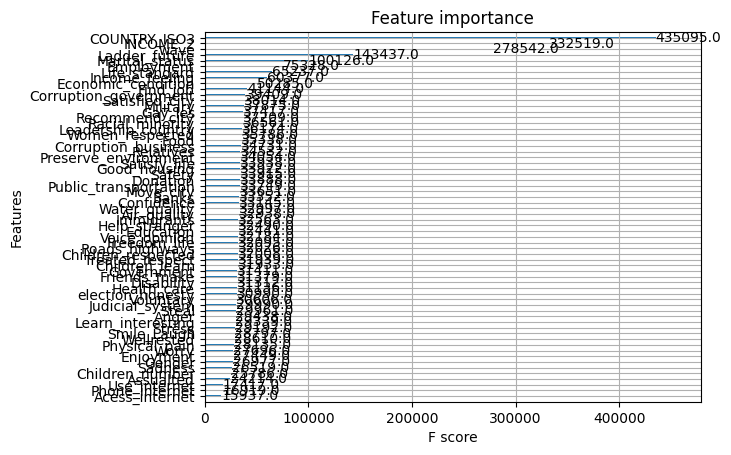

In [36]:
plot_importance(model)
plt.show()

### SHAP for Step 1

#### SHAP values

In [29]:
explainer = shap.TreeExplainer(model)

In [30]:
shap_values = explainer.shap_values(Xe1_train)

In [31]:
print(f"SHAP values shape: {shap_values.shape}")

SHAP values shape: (1770730, 65, 3)


In [49]:
print(f'SHAP values shape: {shap_values[1].shape}')  # For class 1

SHAP values shape: (65, 3)


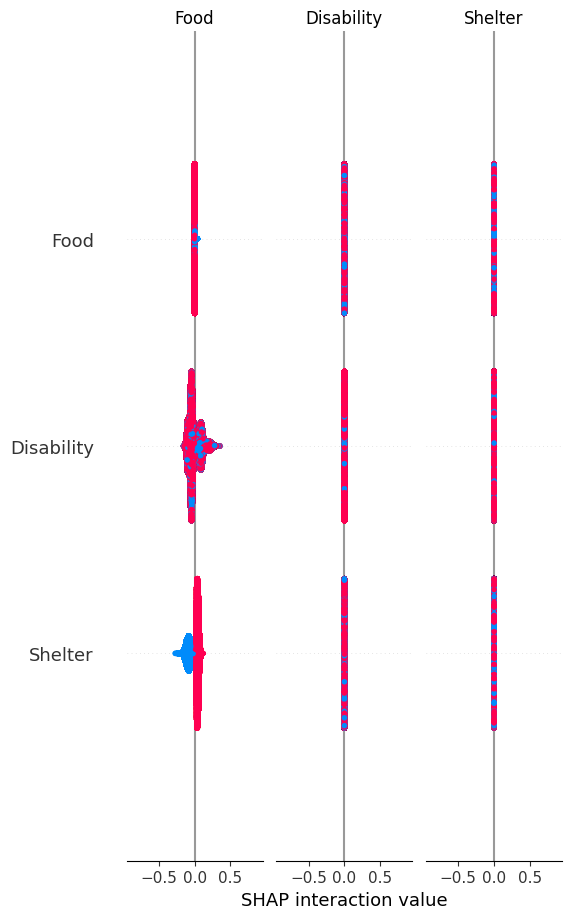

In [53]:
shap.summary_plot(shap_values, Xe1_train, feature_names=feature_names, plot_type="bar", max_display=10)

### Hyperparameter for Step 1

In [33]:
n_estimators_list = list(range(100, 300, 50))
learning_rate_list = [0.05, 0.1]
max_depth_list = [5,10,15]
subsample_list = [0.6, 0.7, 0.8, 0.9, 1]

In [34]:
results_list = []
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            for subsample in subsample_list:
                model = xgb.XGBClassfier(objective='binary:logistic', 
                                         n_estimators = n_estimators,
                                         learning_rate = learning_rate, 
                                         max_depth = max_depth, 
                                         subsample = subsample,
                                         random_state=42, enable_categorical=True  )
                model.fit(Xe_train, ye_train)
                ye_pred = model.predict(Xe_test)
                test_r2 = r2_score(ye_test, ye_pred) * 100
                ye_train_pred = model.predict(Xe_train)
                train_r2 = r2_score(ye_train, ye_train_pred) * 100
                row = [n_estimators, learning_rate, max_depth, 
                       subsample, train_r2, test_r2]
                print(row)
                model = None
                ye_pred = None
                ye_train_pred = None
                results_list.append(row)

[50, 0.05, 5, 0.6, 99.4079357100152, 99.40792611208336]
[50, 0.05, 5, 0.7, 99.40793749453941, 99.40792790509471]
[50, 0.05, 5, 0.8, 99.40793927905838, 99.40792969810079]
[50, 0.05, 5, 0.9, 99.40793927905838, 99.40792969810079]
[50, 0.05, 5, 1, 99.40794022132275, 99.40793063565667]
[50, 0.05, 10, 0.6, 99.4079357100152, 99.40792611208336]
[50, 0.05, 10, 0.7, 99.40793749453941, 99.40792790509471]
[50, 0.05, 10, 0.8, 99.40793927905838, 99.40792969810079]
[50, 0.05, 10, 0.9, 99.40793927905838, 99.40792969810079]
[50, 0.05, 10, 1, 99.40794022132275, 99.40793063565667]
[50, 0.05, 15, 0.6, 99.4079357100152, 99.40792611208336]
[50, 0.05, 15, 0.7, 99.40793749453941, 99.40792790509471]
[50, 0.05, 15, 0.8, 99.40793927905838, 99.40792969810079]
[50, 0.05, 15, 0.9, 99.40793927905838, 99.40792969810079]
[50, 0.05, 15, 1, 99.40794022132275, 99.40793063565667]
[50, 0.1, 5, 0.6, 99.99734373387524, 99.99734369148592]
[50, 0.1, 5, 0.7, 99.99734373387524, 99.99734369148592]
[50, 0.1, 5, 0.8, 99.99734373387

### PSM for Step 1

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

In [26]:
Df.shape

(1967478, 67)

In [30]:
X = Df[['Food', 'Disability','Shelter']]
T = Df['Economic_trend']
le = LabelEncoder()


# Calculate propensity scores
model_PSM = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_PSM.fit(X, T)
propensity_scores = model_PSM.predict_proba(X)

for idx, Economic_trend in enumerate(model_PSM.classes_):
    Df[f'propensity_score_{Economic_trend}'] = propensity_scores[:,idx]


/opt/anaconda3/envs/MLlearning/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [32]:
for idx, level in enumerate(model_PSM.classes_):
    Df[f'propensity_score_{level}'] = propensity_scores[:, idx]

# Step 3: Perform Matching for each treatment level
def match_on_propensity_score(Df, level):
    treated = Df[Df['Economic_trend'] == level]
    control = Df[Df['Economic_trend'] != level]
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[[f'propensity_score_{level}']])
    distances, indices = nn.kneighbors(treated[[f'propensity_score_{level}']])
    matched_control = control.iloc[indices.flatten()]
    return treated, matched_control

matched_data = pd.DataFrame()
for level in model_PSM.classes_:
    treated, matched_control = match_on_propensity_score(Df, level)
    matched_data = pd.concat([matched_data, treated, matched_control])

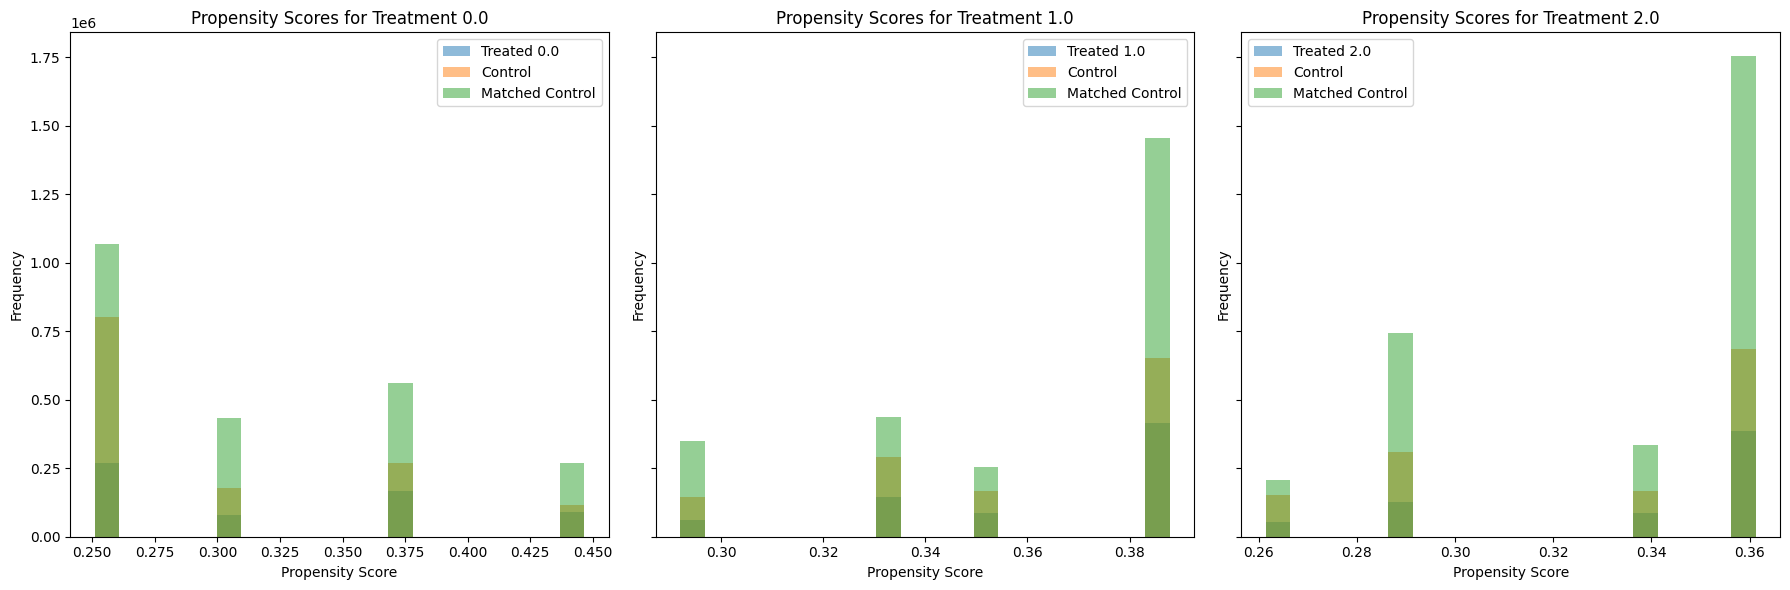

In [33]:
# Step 4: Visualize Propensity Score Distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for idx, level in enumerate(model_PSM.classes_):
    treated = Df[Df['Economic_trend'] == level]
    control = Df[Df['Economic_trend'] != level]
    matched_control = matched_data[matched_data['Economic_trend'] != level]
    
    axs[idx].hist(treated[f'propensity_score_{level}'], bins=20, alpha=0.5, label=f'Treated {level}')
    axs[idx].hist(control[f'propensity_score_{level}'], bins=20, alpha=0.5, label='Control')
    axs[idx].hist(matched_control[f'propensity_score_{level}'], bins=20, alpha=0.5, label='Matched Control')
    axs[idx].set_title(f'Propensity Scores for Treatment {level}')
    axs[idx].set_xlabel('Propensity Score')
    axs[idx].set_ylabel('Frequency')
    axs[idx].legend()

plt.tight_layout()
plt.show()

## Shuffle Conversion for Step 2

In [11]:
#Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
#Df['COUNTRY_ISO3'] = Df['COUNTRY_ISO3'].astype('category')

In [13]:
ye2 = Df['Wellbeing_ladder']

In [14]:
Xe2 = Df.drop(columns=['Wellbeing_ladder','Economic_trend'])

In [15]:
Xe1_train, Xe1_test, ye1_train, ye1_test = train_test_split(Xe1, ye1, test_size=0.1, random_state=42)

In [ ]:
pip install gams